In [1]:
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

import torch

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset

import random
import json

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [4]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

ru_labels = {
    "anger": 'гнев',
    "disgust": 'отвращение',
    "fear": 'страх',
    "joy": 'радость',
    "sadness": 'грусть',
    "surprise": 'удивление',
    "neutral": 'нейтральный'
}

rev_ru_labels = {value: key for key, value in ru_labels.items()}

data = load_dataset("csv", data_files={"train": "train.csv", "validation": "valid.csv"})
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [5]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'k', ',', '🏾', 'Д', 'ʍ', '清', '😡', '☆', '🚀', 'Е', '🙁', '‘', '⭐', 'м', '💁', '😉', 'o', '🌈', '👨', 'Ɲ', 'Ю', '인', '🙊', '🌿', '⠳', 'ī', '@', 'ɐ', '😮', '🤞', 'ь', '♂', 'H', '⠋', '⠚', '💆', '⠻', '🐃', 'И', '🤗', '😱', '什', 'ю', '👸', '👴', '▫', 'Ё', 'z', '💖', 'v', '⠛', '🅱', '🧛', '🖐', 'ə', '\xa0', '👌', 'h', '🔑', 'А', 'G', '😳', '❣', '⣤', 'ы', '⢀', '🥀', '⣷', '🎏', '면', '/', '😕', 'ň', 'т', '🚓', '⢻', '🎖', '⠇', 'Δ', '⚰', 'у', '👎', 'U', '😓', '油', '人', 'ʌ', '😐', '͜', '💡', '©', '玛', '🇸', '💪', '😣', 'Ж', '👩', 'С', 'I', 'S', '\u200d', '🦀', '0', 'Я', 's', '💰', '⠸', '⣆', '😿', 'é', '청', 'з', '你', '💦', '💗', 'Б', 'с', '🍩', '👊', 'Q', 'ß', '=', 'K', '🗑', '8', 'V', 'ñ', '💕', '👉', '⡶', 'E', '💩', '🚒', '🤠', '⡾', 'M', 'и', '💅', '😊', 'ē', '💃', 'Х', '😔', 'ı', 'Ó', '🙋', '🤘', '🤲', '#', '🌹', '✊', 'В', '}', '⣿', 'я', '🇲', '⠘', '⠢', 'п', '👁', '🤭', '☺', '🔪', '💎', '👐', '🎶', '😞', '⠶', '💔', '“', '¯', '🚫', '做', '”', '😢', 'ш', 'ч', '🐢', '⣹', ']', '⠙', '|', '😬', '🤪', '😻', '😟', '😇', '😠', '7', 'Н', 'O', 'ɹ', '?', '—'

#### 📊 Построим гистограммы распределения

In [6]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

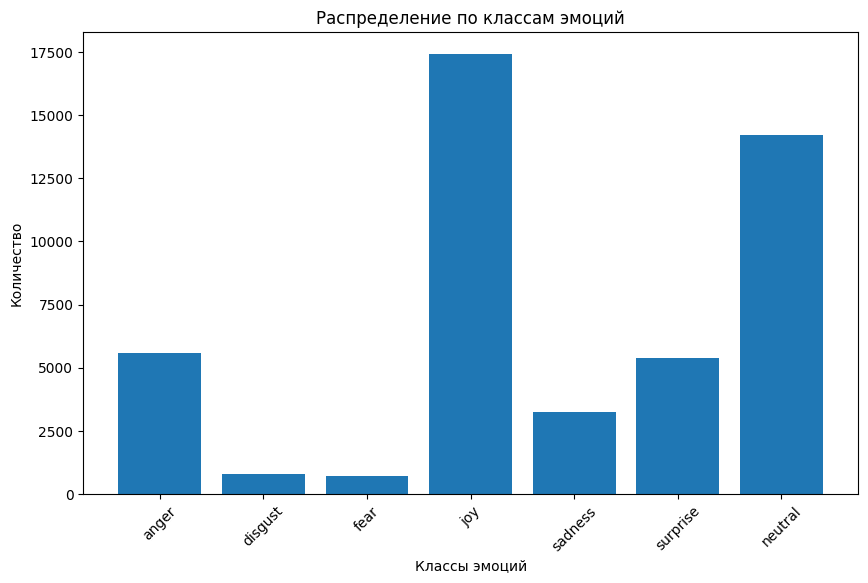

In [7]:
plot_histogram(data["train"])

In [8]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

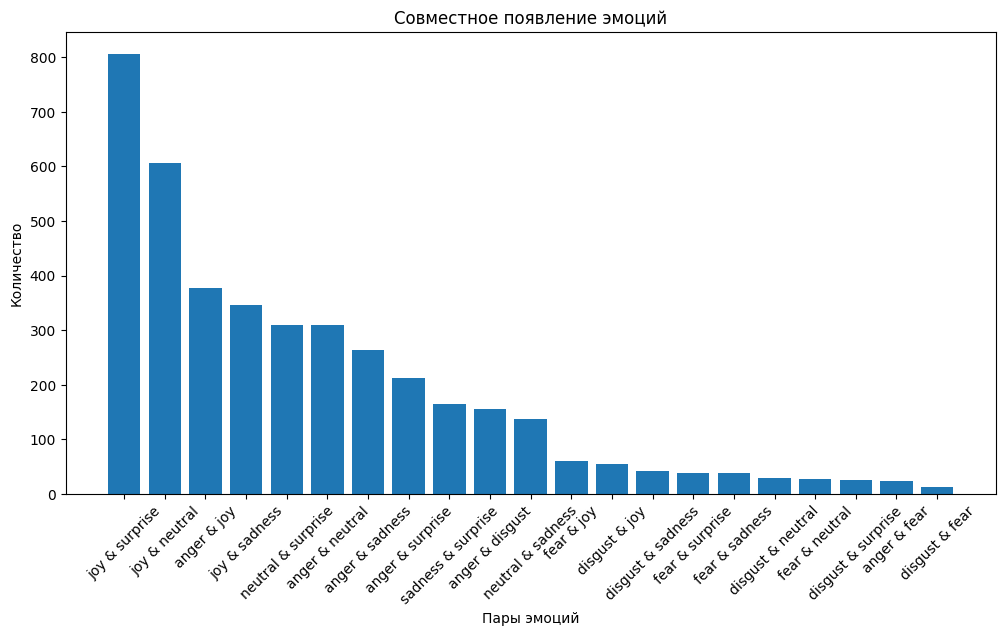

In [9]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [10]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

def label_to_text(example):
    keys = [ru_labels[key] for key in example.keys() if example[key] == 1]
    example['answer'] = ', '.join(keys)
    return example

#### 📒 Подготовим данные для обучения

In [11]:
data = data.map(cleaner)
data = data.map(label_to_text)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [12]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'answer'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'answer'],
        num_rows: 5426
    })
})

In [13]:
data['train'][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0,
 'answer': 'страх'}

In [14]:
dataset_train = data['train']
dataset_valid = data['validation']

print(dataset_train)
print(dataset_valid)

Dataset({
    features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'answer'],
    num_rows: 43410
})
Dataset({
    features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'answer'],
    num_rows: 5426
})


#### 🏋️ Подготовим модель

In [15]:
MAX_LENGTH = 64
MODEL = 'ai-forever/ruT5-base'
BATCH_SIZE = 16
EPOCHS = 3
OUT_DIR = 't5_emotions'

In [16]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [17]:
 def preprocess_function(examples):

    inputs = examples['text']
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length'
    )

    cleaned_tag = examples['answer']

    with tokenizer.as_target_tokenizer():
      labels = tokenizer(
          cleaned_tag,
          max_length=MAX_LENGTH,
          truncation=True,
          padding='max_length'
      )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = dataset_train.map(preprocess_function, batched=True)
tokenized_valid = dataset_valid.map(preprocess_function, batched=True)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [18]:
model = T5ForConditionalGeneration.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

222,903,552 total parameters.
222,903,552 training parameters.


#### 🏃‍♂️‍➡️ Запускаем обучение

In [19]:
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=OUT_DIR,
    logging_steps=100,
    evaluation_strategy='steps',
    save_steps=1000,
    eval_steps=1000,
    load_best_model_at_end=True,
    save_total_limit=3,
    report_to='tensorboard',
    learning_rate=0.0001,
    fp16=True,
    dataloader_num_workers=4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
)

history = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
1000,0.023900,0.023761
2000,0.021500,0.021393
3000,0.020500,0.019772
4000,0.020400,0.019234
5000,0.019200,0.019332
6000,0.017800,0.019769
7000,0.017400,0.019432
8000,0.016700,0.018985


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [20]:
tokenizer.save_pretrained(OUT_DIR)
model.save_pretrained(OUT_DIR)

In [21]:
model = T5ForConditionalGeneration.from_pretrained(OUT_DIR)
model = model.to(device)
tokenizer = T5Tokenizer.from_pretrained(OUT_DIR)

In [22]:
def do_correction(text, model, tokenizer):
    input_text = text
    inputs = tokenizer.encode(
        input_text,
        return_tensors='pt',
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True
    )

    corrected_ids = model.generate(
        inputs.to(device),
        max_length=MAX_LENGTH,
        temperature=0.1,
        top_p=0.75,
        top_k=40,
        num_beams=4,
        early_stopping=True
    )

    corrected_sentence = tokenizer.decode(
        corrected_ids[0],
        skip_special_tokens=True
    )
    return corrected_sentence

In [23]:
from tqdm import tqdm
num_examples = len(dataset_valid)

instructions = dataset_valid[:num_examples]['text']
answers = dataset_valid[:num_examples]['answer']

targets = []
outputs = []

for question, answer in tqdm(list(zip(instructions, answers))):
    output = do_correction(question, model, tokenizer)
    targets.append(answer.split(', '))
    outputs.append(output.split(', '))

  0%|          | 0/5426 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
100%|██████████| 5426/5426 [09:22<00:00,  9.65it/s]


In [24]:
def to_one_hot(responses, labels):
    one_hot_responses = []

    for response in responses:
        one_hot = np.zeros(len(labels), dtype=int)

        for ru_label in response:
            label = rev_ru_labels[ru_label]
            index = labels.index(label)
            one_hot[index] = 1

        one_hot_responses.append(list(one_hot))

    return one_hot_responses

one_hot_targets = to_one_hot(targets, labels)
one_hot_outputs = to_one_hot(outputs, labels)

In [25]:
print(metrics.classification_report(one_hot_targets, one_hot_outputs, target_names=labels))

              precision    recall  f1-score   support

       anger       0.62      0.44      0.52       717
     disgust       0.48      0.41      0.44        97
        fear       0.65      0.50      0.57       105
         joy       0.82      0.80      0.81      2219
     sadness       0.63      0.55      0.59       390
    surprise       0.58      0.45      0.51       624
     neutral       0.63      0.67      0.65      1766

   micro avg       0.70      0.65      0.68      5918
   macro avg       0.63      0.55      0.58      5918
weighted avg       0.69      0.65      0.67      5918
 samples avg       0.70      0.67      0.68      5918



#### ✏️ Получаем результаты на тесте

In [26]:
test = load_dataset("csv", data_files={"test": "test_without_answers.csv"})
dataset_test = test['test']

Generating test split: 0 examples [00:00, ? examples/s]

In [27]:
num_examples = len(dataset_test)
instructions = dataset_test[:num_examples]['text']

test_outputs = []

for question in tqdm(instructions):
    output = do_correction(question, model, tokenizer)
    test_outputs.append(output.split(', '))

  0%|          | 0/8742 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
100%|██████████| 8742/8742 [15:19<00:00,  9.50it/s]


In [28]:
one_hot_test = to_one_hot(test_outputs, labels)

#### 🧑‍🍳 Готовим сабмит

In [29]:
import pandas as pd

df = pd.read_csv("test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [30]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [31]:
df[labels] = one_hot_test

In [32]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,1,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,1,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,1
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,1,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,1


In [33]:
df.index.name = 'id'
df.index += 1
dfdf = df[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']]
dfdf.to_csv("submission.csv", index=True)